# **Apprentissage profond et traitement du signal - TP2**
### Authors:
- Boubacar Sow
- Junior Cedric Tonga

In [1]:
#!pip install numpy
#!pip install sklearn$

# TP2: Détection de menaces radar

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb

2 séances de TP sur ce sujet : le 18 octobre (1h30) et le 25 octobre (3h).<br>
Deadline : 8 novembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus).

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours.

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient:

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence)
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord.

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes.
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus.

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'.

Les signaux ont été divisés en deux ensembles indépendants:
    
- train
- test

Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace.
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'.

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante:

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

## **Importation des bibliothèques**


In [2]:
import numpy as np
import json
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import accuracy_score


<div class=consignes> et les fichiers d'annotations:</div>

In [4]:
with open('./radars/train_labels.json') as f:
    dict_labels_train = json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels_train[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: nonmenace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: nonmenace


In [5]:
with open('./radars/test_labels.json') as f:
    dict_labels_test= json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels_test[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: menace
Le signal pdw-1.npz est de type: menace
Le signal pdw-2.npz est de type: nonmenace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: nonmenace
Le signal pdw-5.npz est de type: menace
Le signal pdw-6.npz est de type: nonmenace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: menace
Le signal pdw-9.npz est de type: menace


<div class=consignes> On compte sur vous, bonne chance ! </div>

In [67]:
with open('./test2_labels.json') as f:
    dict_labels_test2= json.load(f)

for i in range(10):
    print(f"Le signal pdw-{i}.npz est de type: {dict_labels_test2[f'pdw-{i}']}")

Le signal pdw-0.npz est de type: nonmenace
Le signal pdw-1.npz est de type: menace
Le signal pdw-2.npz est de type: menace
Le signal pdw-3.npz est de type: nonmenace
Le signal pdw-4.npz est de type: menace
Le signal pdw-5.npz est de type: nonmenace
Le signal pdw-6.npz est de type: menace
Le signal pdw-7.npz est de type: menace
Le signal pdw-8.npz est de type: nonmenace
Le signal pdw-9.npz est de type: nonmenace


## **Lecture des données**

In [74]:
# Fonction qui combine tous les fichiers(pdw) contenus dans le train ou test set en fonction de leur label dans un dataframe

def read_data(directory,label_type_dic):

  df=pd.DataFrame()
  dic_labels=label_type_dic
   
  for file in tqdm(os.listdir(directory)):
    file_wex=file.split('.')[0]
    if file_wex in dic_labels:

      pdws = np.load(directory+file)
      new_df=pd.DataFrame.from_dict({element: [pdws[element]]for element in pdws.files})

      if dic_labels[file_wex]=='menace':  # nous avons assigné 1 pour la classe non menace et 0 pour la classe menace comme label
        label=0
      elif dic_labels[file_wex]=='nonmenace' :
        label =1

      new_df['label']=label
      df=pd.concat([df,new_df], ignore_index=True)
    else:
      raise Exception('this file is not in label')
    
  return df

In [77]:
#chargement du train et test set dans le dataframe

train_directory= './radars/train/'
test_directory= './radars/test/'
test2 = './test2/'


df_train=read_data(train_directory, dict_labels_train)
df_test= read_data(test_directory,dict_labels_test)
df_test2 = read_data(test2,dict_labels_test2)


100%|██████████| 800/800 [00:04<00:00, 172.02it/s]


In [8]:
print("Train dataframe head")
display(df_train.head())
print("Test dataframe head")
display(df_test.head())

Train dataframe head


,date,largeur,frequence,puissance,theta,phi,label
0,"[10.703, 25.227, 33.699, 73.635, 74.845, 77.26...","[0.107, 0.105, 0.107, 0.106, 0.105, 0.107, 0.1...","[3.504516783787229, 3.4998182206385637, 3.5250...","[-105.54485524865697, -105.72967610849224, -10...","[0.42050025864357987, -0.12749750525406228, 0....","[1.4704837985960901, 1.4182155204263753, 1.677...",1
1,"[13.237, 19.429000000000002, 20.979, 29.495, 4...","[0.167, 0.168, 0.168, 0.168, 0.168, 0.167, 0.1...","[0.6013467718763973, 0.5994499528433231, 0.604...","[-139.10401311807288, -136.34299446318016, -13...","[-0.7800515760837143, -0.6837307506277697, -0....","[1.7531435088816525, 1.9534050722526026, 1.284...",0
2,"[25.507, 34.781, 39.419000000000004, 61.832, 7...","[0.074, 0.073, 0.073, 0.073, 0.074, 0.073, 0.0...","[1.6134275872320052, 1.6136817067181528, 1.612...","[-122.31261171524994, -122.3672547286434, -122...","[2.599461672585036, 2.586536667693927, 2.83432...","[1.7381764607265469, 1.5071792538800237, 1.384...",1
3,"[1.302, 6.628, 31.469, 33.244, 65.187, 70.508,...","[0.232, 0.232, 0.23, 0.232, 0.231, 0.231, 0.23...","[2.870174278578111, 2.857339854221217, 2.86760...","[-146.77479107324757, -147.83857595106443, -14...","[1.7923233777006349, 2.1254293210079744, 1.690...","[1.6145758404649442, 1.4292583586007475, 1.532...",0
4,"[12.513, 19.836000000000002, 34.48000000000000...","[0.154, 0.153, 0.152, 0.154, 0.153, 0.152, 0.1...","[0.879922675147697, 0.8462196840083602, 0.8534...","[-148.5105574965002, -155.03510153185368, -153...","[-2.2023332264280397, -2.6479162319051075, -2....","[1.5974554495119468, 1.596032512536647, 2.0284...",0


Test dataframe head


,date,largeur,frequence,puissance,theta,phi,label
0,"[1.437, 3.822, 4.0040000000000004, 5.104, 7.12...","[0.021, 0.019, 0.02, 0.02, 0.021, 0.021, 0.021...","[1.4863529411353804, 1.6722673471845029, 1.552...","[-132.22993583077883, -132.39180857797442, -13...","[-2.4598789192007993, -2.616933270707026, -2.6...","[1.5412760401284227, 1.5883701761011755, 1.659...",0
1,"[0.6880000000000001, 10.15, 11.412, 21.505, 28...","[0.08700000000000001, 0.08700000000000001, 0.0...","[0.720233669334392, 0.7178179377672744, 0.7105...","[-96.40545532736824, -96.90077812827651, -96.8...","[-2.2476664793239767, -2.262536569349665, -2.3...","[1.6451613060471157, 1.6948112571745233, 1.908...",0
2,"[0.5680000000000001, 5.641, 7.815, 8.903, 9.62...","[0.035, 0.037, 0.037, 0.037, 0.035, 0.037, 0.0...","[1.4290735030472799, 1.423545068435542, 1.4231...","[-125.60551594833373, -126.32239533506358, -12...","[2.758009084555207, 2.4968607667861313, 2.8023...","[1.463622100013936, 1.583585065051975, 1.34248...",1
3,"[21.534, 33.378, 38.455, 72.296, 92.6030000000...","[0.369, 0.371, 0.37, 0.37, 0.37, 0.37, 0.37, 0...","[0.8436476992836878, 0.8416099565658522, 0.850...","[-93.35734184704127, -92.800302167067, -93.255...","[-2.739671816435371, -2.5231196506485185, -2.4...","[1.3725492315554315, 1.8544734931153268, 1.874...",0
4,"[3.359, 15.556000000000001, 29.493000000000002...","[0.094, 0.095, 0.095, 0.095, 0.095, 0.096, 0.0...","[2.1814188160956163, 2.174139093415879, 2.1868...","[-143.88048467512684, -145.68684332674408, -14...","[-1.8552203745529634, -1.3932714572747522, -1....","[1.3512229787461194, 1.5444681512674094, 1.398...",1


# **Exploration des données**

- distribution des classes dans le train set 

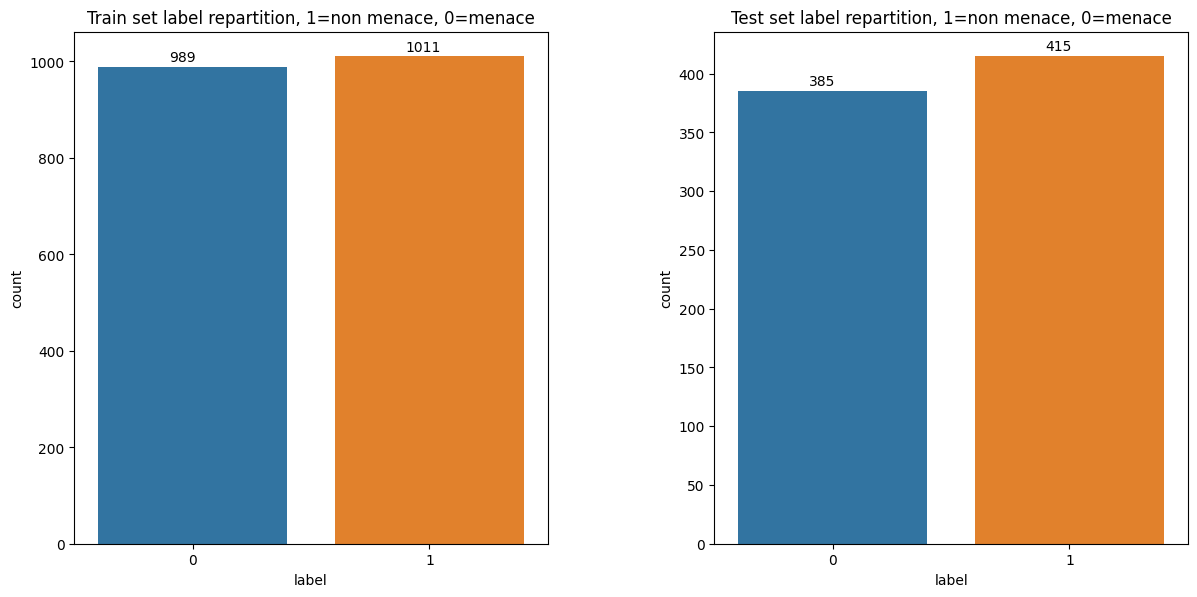

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

# Plot for train set
sns.countplot(x='label', data=df_train, ax=axs[0])
axs[0].set_title('Train set label repartition, 1=non menace, 0=menace')
axs[0].text(x=-0.1, y=1000, s=df_train[df_train['label']==0].shape[0])
axs[0].text(x=0.9, y=1020, s=df_train[df_train['label']==1].shape[0])

# Plot for test set
sns.countplot(x='label', data=df_test, ax=axs[1])
axs[1].set_title('Test set label repartition, 1=non menace, 0=menace')
axs[1].text(x=-0.1, y=390, s=df_test[df_test['label']==0].shape[0])
axs[1].text(x=0.9, y=420, s=df_test[df_test['label']==1].shape[0])

plt.tight_layout(pad=8.0)
plt.show()


### **Commentaire** :
 nous avons assigné **1 pour la classe non menace** et **0 pour la classe menace** comme label. Ensuite on remarque que la classe menace(0) a moins de label que la classe non label(1). Bien qu'il y'a une différence pas trop grande de 22 labels entre les deux classes,
nous pouvons considerer que les classes ne sont pas désequilibré( unbalanced).

 

In [10]:
print("Train dataframe info")
display(df_train.info())
print("Test dataframe info")
display(df_test.info())
print("Train dataframe columns shape")
display(df_train.iloc[0,:].map(lambda x: x.shape))
print("Test dataframe columns shape")
display(df_train.iloc[1,:].map(lambda x: x.shape))

Train dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2000 non-null   object
 1   largeur    2000 non-null   object
 2   frequence  2000 non-null   object
 3   puissance  2000 non-null   object
 4   theta      2000 non-null   object
 5   phi        2000 non-null   object
 6   label      2000 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 109.5+ KB


None

Test dataframe info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       800 non-null    object
 1   largeur    800 non-null    object
 2   frequence  800 non-null    object
 3   puissance  800 non-null    object
 4   theta      800 non-null    object
 5   phi        800 non-null    object
 6   label      800 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 43.9+ KB


None

Train dataframe columns shape


date         (789,)
largeur      (789,)
frequence    (789,)
puissance    (789,)
theta        (789,)
phi          (789,)
label            ()
Name: 0, dtype: object

Test dataframe columns shape


date         (1294,)
largeur      (1294,)
frequence    (1294,)
puissance    (1294,)
theta        (1294,)
phi          (1294,)
label             ()
Name: 1, dtype: object

In [11]:
df_train.isna().sum() # Nous pouvons voir qu'on a pas d'élement nul dans le train set

date         0
largeur      0
frequence    0
puissance    0
theta        0
phi          0
label        0
dtype: int64

### **Commentaire**  : 
Nous avons affiché la taille de notre dataset plus haut. Nous avons aussi afficher la taille de deux echantillons où 
nous pouvons remarqué que l'on a pas la même taille entre les échantillons.

- Visualisation des données

Nous avons commencé par visualiser comment les caractéristiques du signal ( fréquence, puissance...)varient en fonction de la date d'impulsions pour un échantillon ménace et non ménace.

Text(0.5, 1.0, 'puissance=f(dates)non menace ')

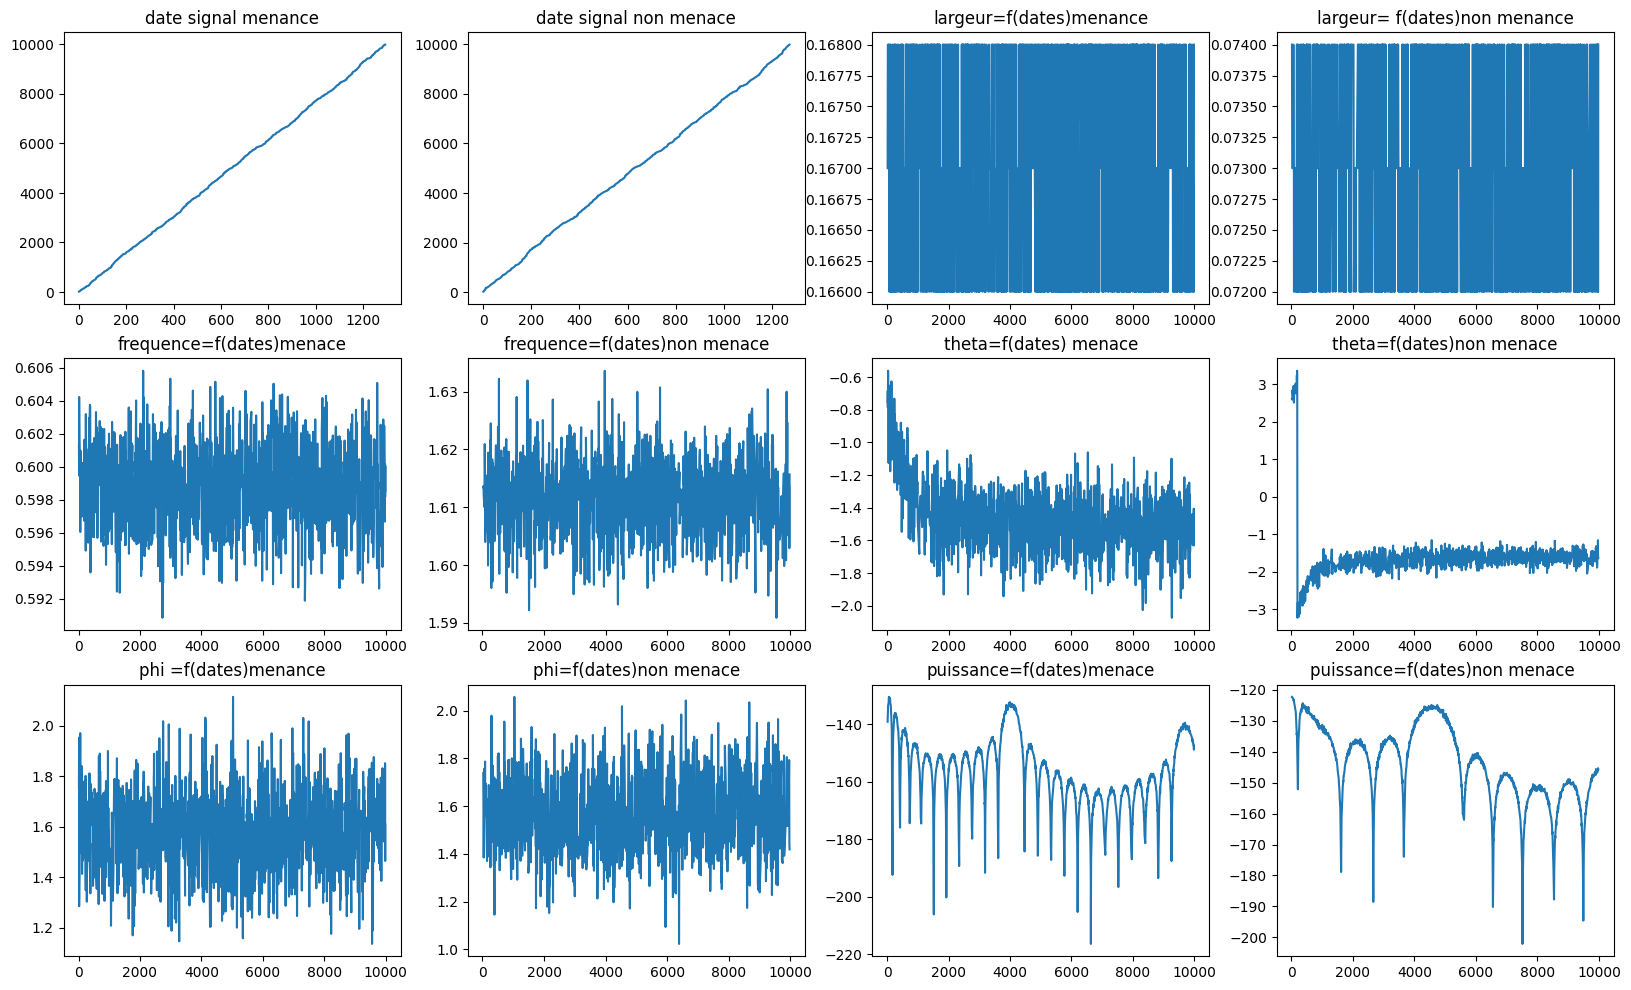

In [12]:
# caractéristique d'un signaux menace
dates_menace = df_train.iloc[1,0]
largeurs_menace = df_train.iloc[1,1]
frequences_menace=df_train.iloc[1,2]
puissances_menace = df_train.iloc[1,3]
theta_menace =df_train.iloc[1,4]
phi_menace = df_train.iloc[1,5]



# aractéristique d'un signaux non menace

dates_nonmenace = df_train.iloc[2,0]
largeurs_nonmenace = df_train.iloc[2,1]
frequences_nonmenace=df_train.iloc[2,2]
puissances_nonmenace = df_train.iloc[2,3]
theta_nonmenace =df_train.iloc[2,4]
phi_nonmenace = df_train.iloc[2,5]



fig, axes= plt.subplots(3,4, figsize=(20,12))
axes[0,0].plot(dates_menace)
axes[0,0].set_title('date signal menance')
axes[0,1].plot(dates_nonmenace)
axes[0,1].set_title('date signal non menace')
axes[0,2].plot(dates_menace,largeurs_menace )
axes[0,2].set_title('largeur=f(dates)menance')
axes[0,3].plot(dates_nonmenace,largeurs_nonmenace)
axes[0,3].set_title('largeur= f(dates)non menance')
axes[1,0].plot(dates_menace,frequences_menace)
axes[1,0].set_title('frequence=f(dates)menace')
axes[1,1].plot(dates_nonmenace,frequences_nonmenace)
axes[1,1].set_title('frequence=f(dates)non menace')
axes[1,2].plot(dates_menace,theta_menace)
axes[1,2].set_title('theta=f(dates) menace')
axes[1,3].plot(dates_nonmenace,theta_nonmenace)
axes[1,3].set_title('theta=f(dates)non menace')
axes[2,0].plot(dates_menace,phi_menace)
axes[2,0].set_title('phi =f(dates)menance')
axes[2,1].plot(dates_nonmenace, phi_nonmenace)
axes[2,1].set_title('phi=f(dates)non menace')
axes[2,2].plot(dates_menace,puissances_menace)
axes[2,2].set_title('puissance=f(dates)menace')
axes[2,3].plot(dates_nonmenace,puissances_nonmenace)
axes[2,3].set_title('puissance=f(dates)non menace ')


### **Commentaire** : 
- Nous pouvons déjà observer plusieurs chose: 
    -  Pour la caractéristique date, nous n'observons pas grand chose vu que la courbe n'est que linéaire.
    - Les largeurs entre signal menace et non menace n'est pas la même. Effet celui d'un signal avec menace est plus grand (autour de 0.18) que celui sans ménace(autour de 0.028).
    -  Pour la puissance on remarque que le nombre maximun pour un signal avec ménace est est plus grand que celui d'un signal non ménace. 
    Donc en fonction du temps les signaux avec ménaces passent beaucoup par 0.
    - Les signaux avec ménaces varient beaucoup comparé à ceux sans ménaces. La fréquence avec ménace stagne autour de de 0.9 à 1.07 alors que celui avec sans ménace tourne autour de 3.98 à 4.08

### Caractéristiques statistiques des données pour mieux visualiser.
    - Vu que les données sont des listes pour chaque exemple examplaire pour les features. Nous avons utilisé regroupé ces listes en leur propriété statistiques (moyenne et variance) afin d'avoir  un nombre par echantillon de caractéristique afin de pouvoir faire une visualisation plus profonde et ressortir plus d'informations.

In [15]:
def get_mean(date):

    """
    Cette fonction calcule la moyenne de durée entre deux impulsions
    """

    return np.mean([date[i+1]-date[i] for i in range(len(date)-1)])
def get_var(date):

    """
    Cette fonction calcule la variance de durée entre deux impulsions
    """
    return np.var([date[i+1]-date[i] for i in range(len(date)-1)])

In [79]:
# Calculate mean and std for each feature
df_train_mean = df_train.drop(['label', 'date'], axis=1).applymap(np.mean)
df_train_var = df_train.drop(['label', 'date'], axis=1).applymap(np.var)

df_test_mean = df_test.drop(['label', 'date'], axis=1).applymap(np.mean)
df_test_var = df_test.drop(['label', 'date'], axis=1).applymap(np.var)

df_test2_mean = df_test2.drop(['label', 'date'], axis=1).applymap(np.mean)
df_test2_var = df_test2.drop(['label', 'date'], axis=1).applymap(np.var)

df_train_var['date']=df_train['date'].map(get_var)
df_test_var['date']=df_test['date'].map(get_var)
df_train_mean['date']=df_train['date'].map(get_mean)
df_test_mean['date']=df_test['date'].map(get_mean)

df_test2_var['date']=df_test2['date'].map(get_var)
df_test2_mean['date']=df_test2['date'].map(get_mean)

df_train_mean = pd.concat([df_train_mean.add_suffix('_mean')], axis=1)
df_train_var = pd.concat([df_train_var.add_suffix('_var')], axis=1)

df_test_mean = pd.concat([df_test_mean.add_suffix('_mean')], axis=1)
df_test_var = pd.concat([df_test_var.add_suffix('_var')], axis=1)

df_test2_mean = pd.concat([df_test2_mean.add_suffix('_mean')], axis=1)
df_test2_var = pd.concat([df_test2_var.add_suffix('_var')], axis=1)

# Combine mean, std and countSup into one DataFrame
df_train_concat = pd.concat([df_train_mean, 
                               df_train_var], axis=1)

df_test_concat = pd.concat([df_test_mean, 
                               df_test_var], axis=1)

df_test2_concat = pd.concat([df_test2_mean,
                                df_test2_var], axis=1)


x_train_concat, y_train_concat = df_train_concat.values, df_train['label'].values
x_test_concat, y_test_concat = df_test_concat.values, df_test['label'].values

df_train_concat['label'] = df_train['label'].values
df_test_concat['label'] = df_test['label'].values
df_train_mean['label'] = df_train['label'].values
df_train_var['label'] = df_train['label'].values

df_test2_concat['label'] = df_test2['label'].values


print("Train_mean dataframe head")
display(df_train_mean.head())
print("Train_var dataframe head")
display(df_train_var.head())
print("Train_concat dataframe")
display(df_train_concat.head())
print("Test2 head")
display(df_test2_concat.head())



Train_mean dataframe head


,largeur_mean,frequence_mean,puissance_mean,theta_mean,phi_mean,date_mean,label
0,0.106058,3.523920,-147.693806,-1.418475,1.571395,12.639760,1
1,0.167024,0.598768,-156.612414,-1.462077,1.573843,7.716510,0
2,0.072992,1.611386,-143.561300,-1.652608,1.570277,7.808895,1
3,0.231002,2.861525,-160.184510,-1.492153,1.569485,18.645685,0
4,0.152999,0.805362,-176.189119,-1.620159,1.575006,10.479949,0


Train_var dataframe head


,largeur_var,frequence_var,puissance_var,theta_var,phi_var,date_var,label
0,6.531282e-07,0.000200,157.342659,0.095192,0.024085,130.510656,1
1,6.848975e-07,0.000006,149.190332,0.041658,0.023836,52.336408,0
2,6.509189e-07,0.000040,149.074168,0.378239,0.023333,59.384471,1
3,6.536278e-07,0.000133,138.657194,0.434102,0.022157,363.332517,0
4,6.530387e-07,0.002225,124.537484,0.032426,0.026774,91.330139,0


Train_concat dataframe


,largeur_mean,frequence_mean,puissance_mean,theta_mean,phi_mean,date_mean,largeur_var,frequence_var,puissance_var,theta_var,phi_var,date_var,label
0,0.106058,3.523920,-147.693806,-1.418475,1.571395,12.639760,6.531282e-07,0.000200,157.342659,0.095192,0.024085,130.510656,1
1,0.167024,0.598768,-156.612414,-1.462077,1.573843,7.716510,6.848975e-07,0.000006,149.190332,0.041658,0.023836,52.336408,0
2,0.072992,1.611386,-143.561300,-1.652608,1.570277,7.808895,6.509189e-07,0.000040,149.074168,0.378239,0.023333,59.384471,1
3,0.231002,2.861525,-160.184510,-1.492153,1.569485,18.645685,6.536278e-07,0.000133,138.657194,0.434102,0.022157,363.332517,0
4,0.152999,0.805362,-176.189119,-1.620159,1.575006,10.479949,6.530387e-07,0.002225,124.537484,0.032426,0.026774,91.330139,0


Test2 head


,largeur_mean,frequence_mean,puissance_mean,theta_mean,phi_mean,date_mean,largeur_var,frequence_var,puissance_var,theta_var,phi_var,date_var,label
0,0.018995,2.659898,-149.614034,-1.583862,1.575707,1.797269,6.659804e-07,0.000108,103.703481,0.611990,0.025034,3.012497,1
1,0.055992,1.167929,-173.146864,-1.535269,1.579018,6.858174,6.563217e-07,0.000021,154.241430,0.359666,0.023157,41.681346,1
2,0.013005,0.904629,-162.166404,-1.669435,1.574702,1.185757,6.679807e-07,0.002740,139.727352,0.037622,0.024683,1.211532,0
3,0.196934,1.670690,-162.061536,-1.683117,1.571491,19.493528,6.557465e-07,0.000045,114.059741,0.052402,0.025728,351.044531,0
4,0.009001,2.583522,-156.327708,-1.597324,1.571959,0.686615,6.669398e-07,0.000108,119.069612,0.025634,0.024922,0.427656,1


Combinaison des propriétés statistiques (moyenne et variance) pour former un dataframe 

- Encore un peu de visualisation de ces nouveaux features

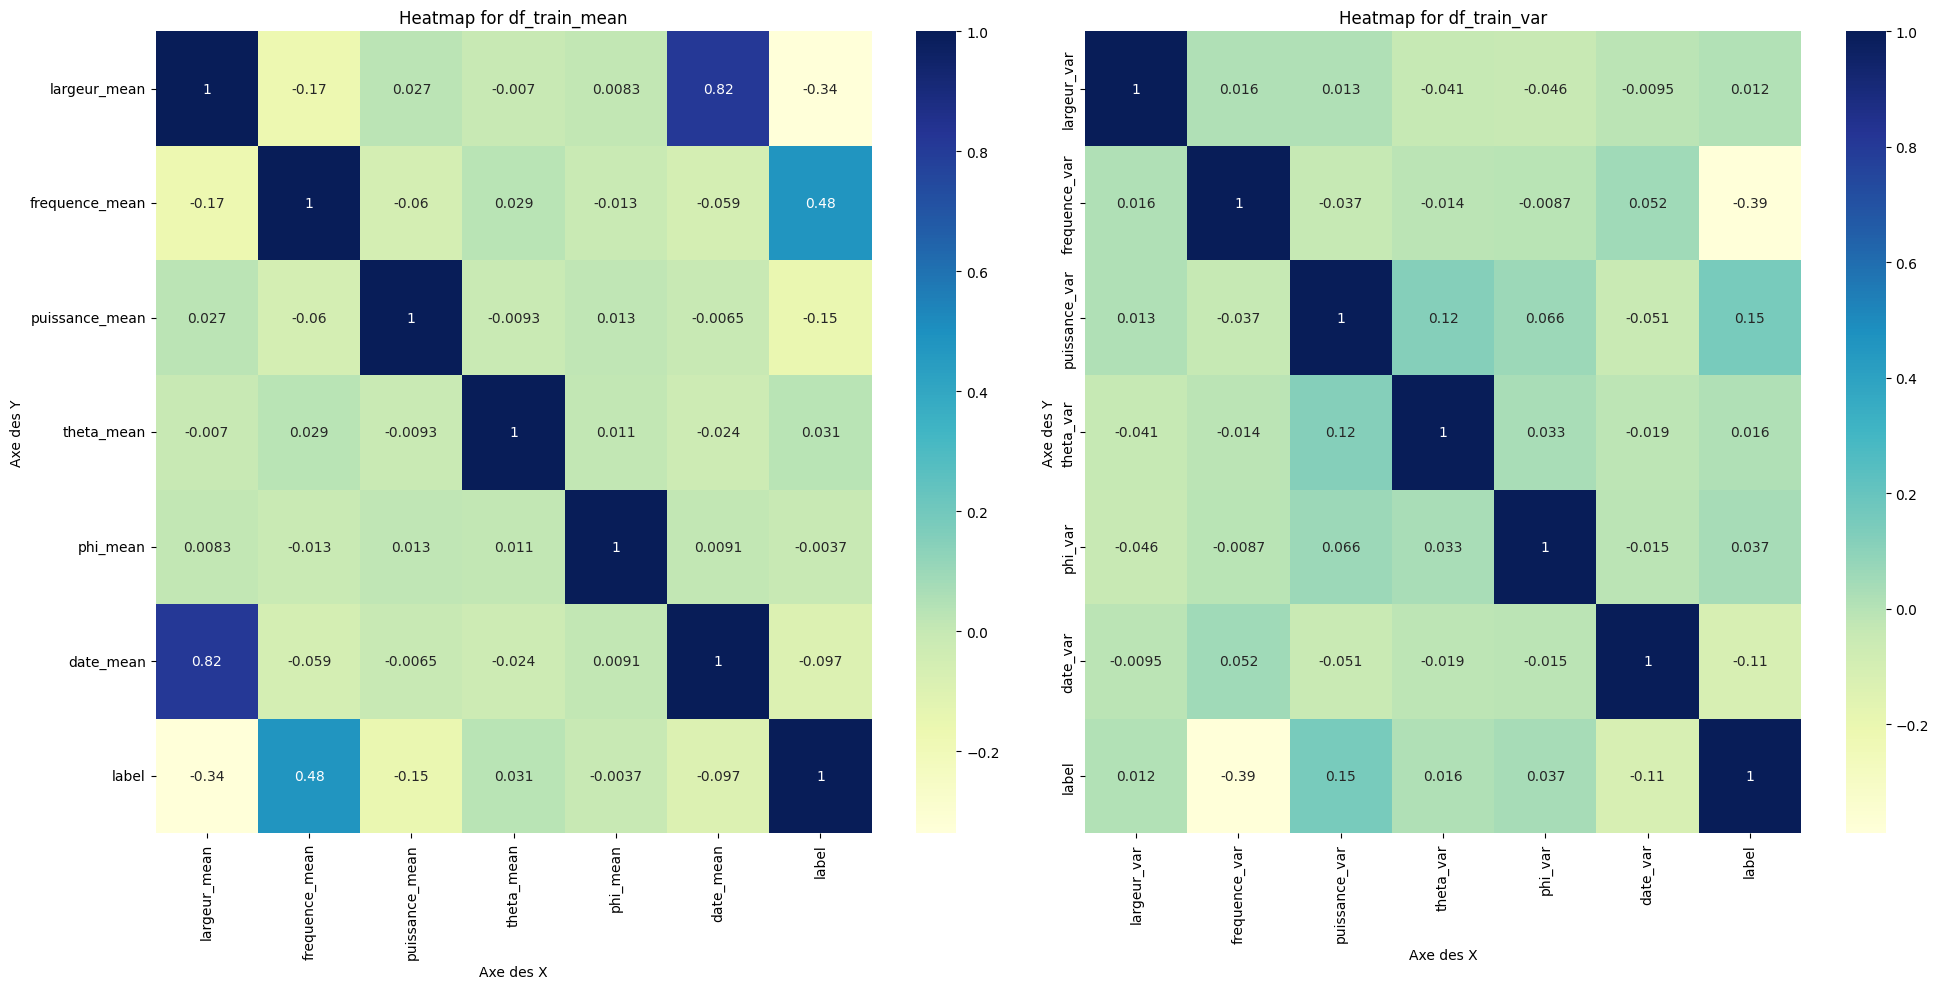

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Heatmap for df_train_mean
sns.heatmap(df_train_mean.corr(), annot=True, cmap="YlGnBu", ax=axs[0])
axs[0].set_xlabel("Axe des X")
axs[0].set_ylabel("Axe des Y")
axs[0].set_title("Heatmap for df_train_mean")

# Heatmap for df_train_var
sns.heatmap(df_train_var.corr(), annot=True, cmap="YlGnBu", ax=axs[1])
axs[1].set_xlabel("Axe des X")
axs[1].set_ylabel("Axe des Y")
axs[1].set_title("Heatmap for df_train_var")

plt.tight_layout()
plt.show()


### Commentaire:
On note de forte correlation entre certaines variables et le label. C'est le cas par exemple de la fréquence_mean, puissance_mean(inversement corrélé) et largeur_mean (inversement correlé). On pourra supposer que ces variables seront importantes pour la classification. 

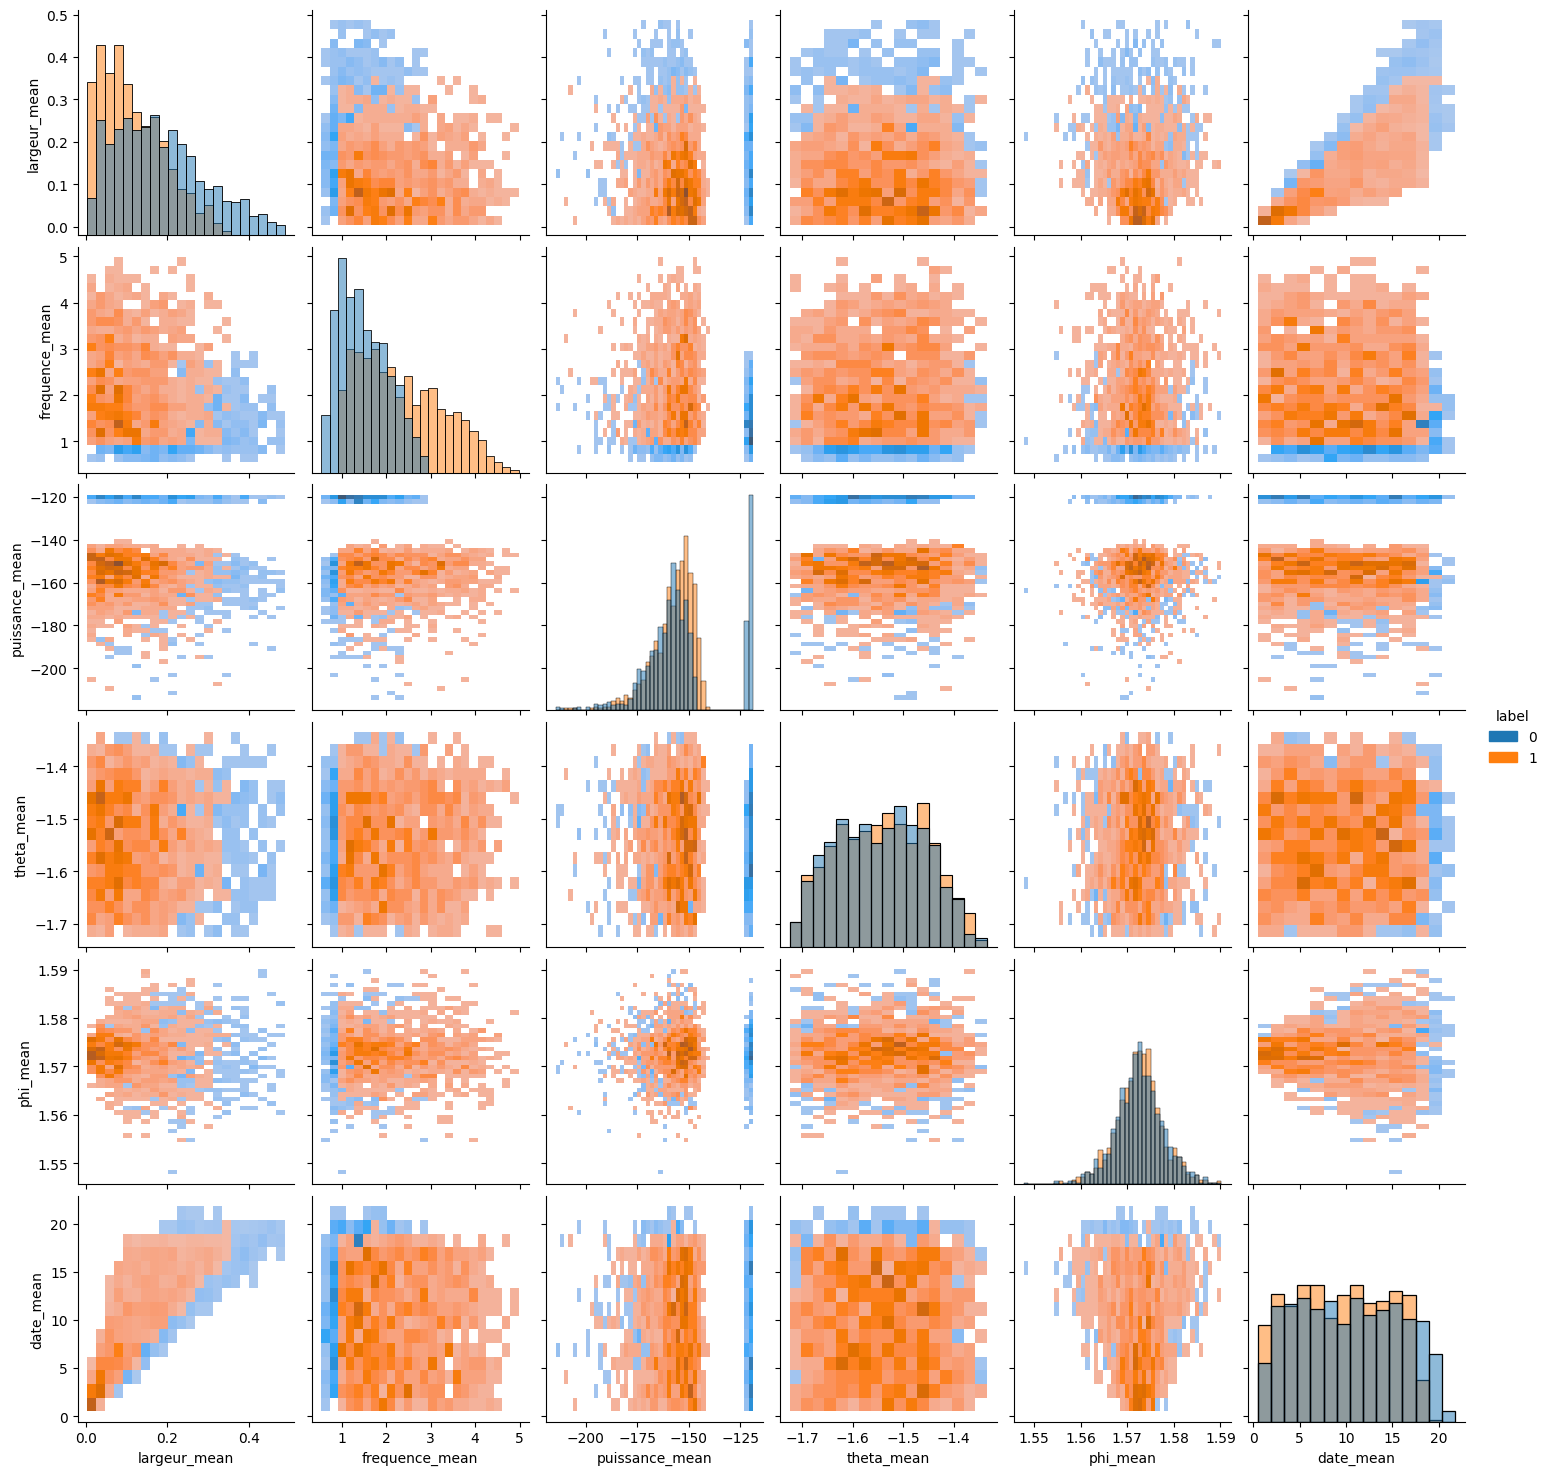

In [18]:
# pairplot des moyennes de features 
sns.pairplot(df_train_mean, kind='hist',hue="label")

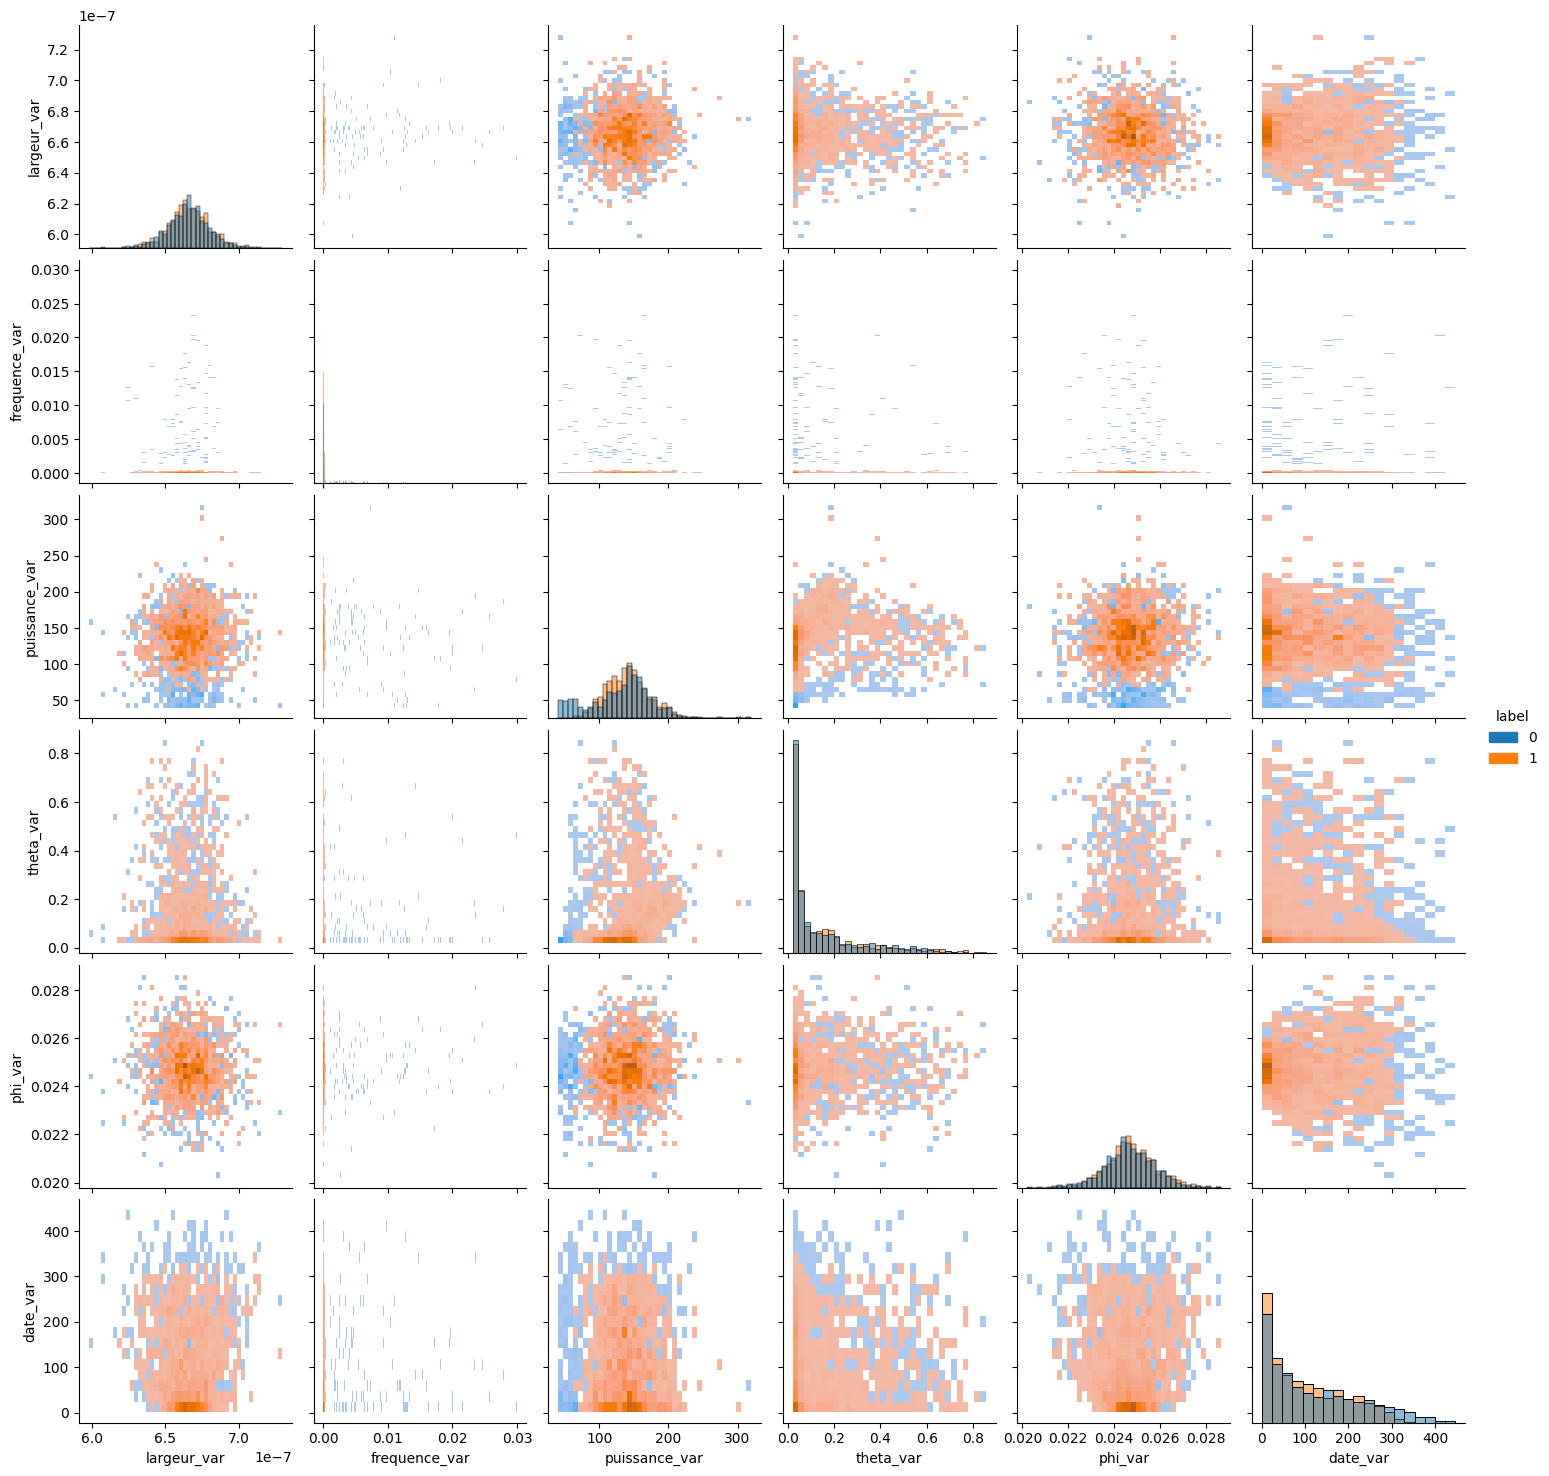

In [19]:
# pairplot des moyennes de features 
sns.pairplot(df_train_var, kind='hist',hue="label")

### Commentaire :
- Nous remarquons que pour la puissance_mean et puissance_var, on a certains élements qui sont isolé respectivement vers -125 et 100. 
- La largeur_man nous montre les largeurs ne sont pas distribués de la même façon pour les deux classes. De plus la largeur_var  donne une gaussienne centré vers 6.5. 
- Nous pouvons dire grâce aux deux visualisations précedentes que la le mean et la variance de la largeur, de la frequence, puissance et des dates peuvent être intéressantes pour la classification.
- Nous allons essayer un algorithme de selection de features pour verifier que l'algorithme choisit ces variables comme importantes. 

# **Construction d'un modèle de prédiction**

##  Baselines

In [20]:
def models_train(X_train, y_train, X_test,y_test):

    names=[ "Nearest Neighbors", "Decision Tree","Random Forest", "AdaBoost", "Naive Bayes","GB","ET","Logistic Regression"]


    classifiers=[KNeighborsClassifier(), DecisionTreeClassifier(), 
    RandomForestClassifier(), AdaBoostClassifier(),GaussianNB(),GradientBoostingClassifier(),ExtraTreesClassifier(),LogisticRegression(max_iter=10000)]

    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score= clf.score(X_test, y_test)
        print('score of  {} is {}'.format(name, score))

In [21]:
models_train(df_train_mean.drop('label', axis=1), df_train['label'], df_test_mean, df_test['label'])

score of  Nearest Neighbors is 0.7075
score of  Decision Tree is 0.77125


score of  Random Forest is 0.78
score of  AdaBoost is 0.7925
score of  Naive Bayes is 0.7
score of  GB is 0.805
score of  ET is 0.785
score of  Logistic Regression is 0.7475


On pourrait aussi proposer une baseline naive qui se baserait uniquement sur la fréquence des signaux. On pourrait dire que si la fréquence moyenne du signal est suppérieure à un seuil, alors c'est un signe de ménace.

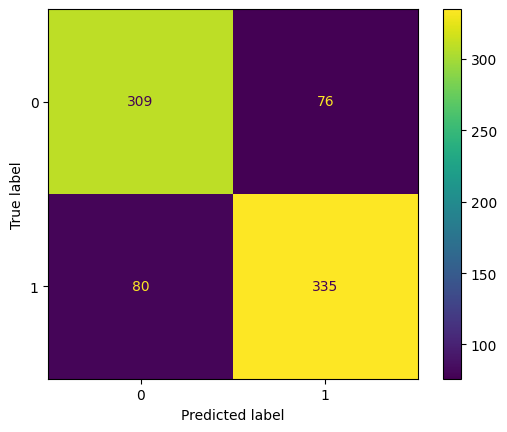

In [22]:
#  Confusion matrice avec le meilleur modèle GB
clf=GradientBoostingClassifier().fit(df_train_mean.drop('label', axis=1), df_train['label'])
prediction = clf.predict(df_test_mean)
cm = confusion_matrix(df_test['label'], prediction, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
#print(accuracy_score(y_test,prediction))
disp.plot()
plt.show()

## **Construction d'un meilleur modèle de prédiction**

#### *Feature selection : Quelles features sont les plus importantes?*

In [23]:

# Feature Importance with Extra Trees Classifier
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(df_train_mean.drop('label', axis=1), df_train['label'])
feature_importance_df = pd.DataFrame(model.feature_importances_).T
feature_importance_df.columns = df_train_mean.drop('label', axis=1).columns
feature_importance_df

,largeur_mean,frequence_mean,puissance_mean,theta_mean,phi_mean,date_mean
0,0.209993,0.293392,0.178552,0.08915,0.091356,0.137556


Commentaire :
Nous avons dans l'ordre du plus important au moins les features importantes (nous avons pris les 4 premiers) : frequence_mean, largeur_mean, puissance_mean, date_mean

In [24]:
model = ExtraTreesClassifier()
model.fit(df_train_var.drop('label', axis=1), df_train['label'])
feature_importance_df = pd.DataFrame(model.feature_importances_).T
feature_importance_df.columns = df_train_var.drop('label', axis=1).columns
feature_importance_df

,largeur_var,frequence_var,puissance_var,theta_var,phi_var,date_var
0,0.001124,0.425211,0.191155,0.121821,0.120164,0.140526


Commentaire: 
Nous avons dans l'ordre du plus important au moins les features importantes (nous avons pris les 4 premiers) : frequence_var, puissance_var, date_var, theta_var

In [25]:
model = ExtraTreesClassifier()
model.fit(df_train_concat.drop('label', axis=1), df_train['label'])
feature_importance_df = pd.DataFrame(model.feature_importances_).T
feature_importance_df.columns = df_train_concat.drop('label', axis=1).columns
feature_importance_df

,largeur_mean,frequence_mean,puissance_mean,theta_mean,phi_mean,date_mean,largeur_var,frequence_var,puissance_var,theta_var,phi_var,date_var
0,0.129404,0.200419,0.103365,0.040079,0.04062,0.058661,0.00052,0.220623,0.069989,0.040492,0.040193,0.055635


Commentaire: Nous avons dans l'ordre du plus important au moins les features importantes (nous avons pris les 7 premiers) : frequence_var, puissance_mean, frequence_mean, largeur_mean, puissance_var, date, date_mean, date_var


In [80]:
# Select features
X_train_selected_features = df_train_concat[['largeur_mean', 'frequence_mean', 'puissance_mean', 'frequence_var', 'puissance_var', 'date_mean']]
# Select features
X_test_selected_features = df_test_concat[['largeur_mean', 'frequence_mean', 'puissance_mean', 'frequence_var', 'puissance_var', 'date_mean']]
# Select features
X_test2_selected_features = df_test2_concat[['largeur_mean', 'frequence_mean', 'puissance_mean', 'frequence_var', 'puissance_var', 'date_mean']]


1. Evaluation des modèles en utilisant les features mean et variances (largeur_mean, largeur_var, etc)
  

In [27]:
models_train(x_train_concat,y_train_concat,x_test_concat,y_test_concat)

score of  Nearest Neighbors is 0.58625
score of  Decision Tree is 0.81625


score of  Random Forest is 0.83625
score of  AdaBoost is 0.84
score of  Naive Bayes is 0.74
score of  GB is 0.84625
score of  ET is 0.8325
score of  Logistic Regression is 0.7425


2. Evaluation des modèles en utilisant les features mean et variances (largeur_mean, largeur_var, etc)
   Cette fois-ci on se restreint uniquement aux features les plus importantes

In [28]:
models_train(X_train_selected_features,y_train_concat,X_test_selected_features,y_test_concat)

score of  Nearest Neighbors is 0.61125
score of  Decision Tree is 0.81625
score of  Random Forest is 0.84625
score of  AdaBoost is 0.84375
score of  Naive Bayes is 0.785
score of  GB is 0.8425
score of  ET is 0.83875
score of  Logistic Regression is 0.745


### Commentaire 
Nous constatons que dans l'ensemble, la prédiction sur les features les plus importantes aide à améliorer le score des modèles.
Dans ce cas c'est le modèle Adaboost qui donne le meilleur score et on remarque que l'accuracy est plus grande ici que dans le premier cas.
On va donc partir avec ce modèle et essayer de le tuner pour améliorer ces performances

### **Tuning des meiileurs modèles**

In [29]:
# renovoie un dframe avec l'importance de chaque feature dans le model 
def feature_importance(model,X):
    feat_imp=model.feature_importances_
    df=pd.DataFrame(feat_imp, index= list(X.columns),columns=['feature_importance'])
    return df


Text(0, 0.5, "pourcentage d'importance")

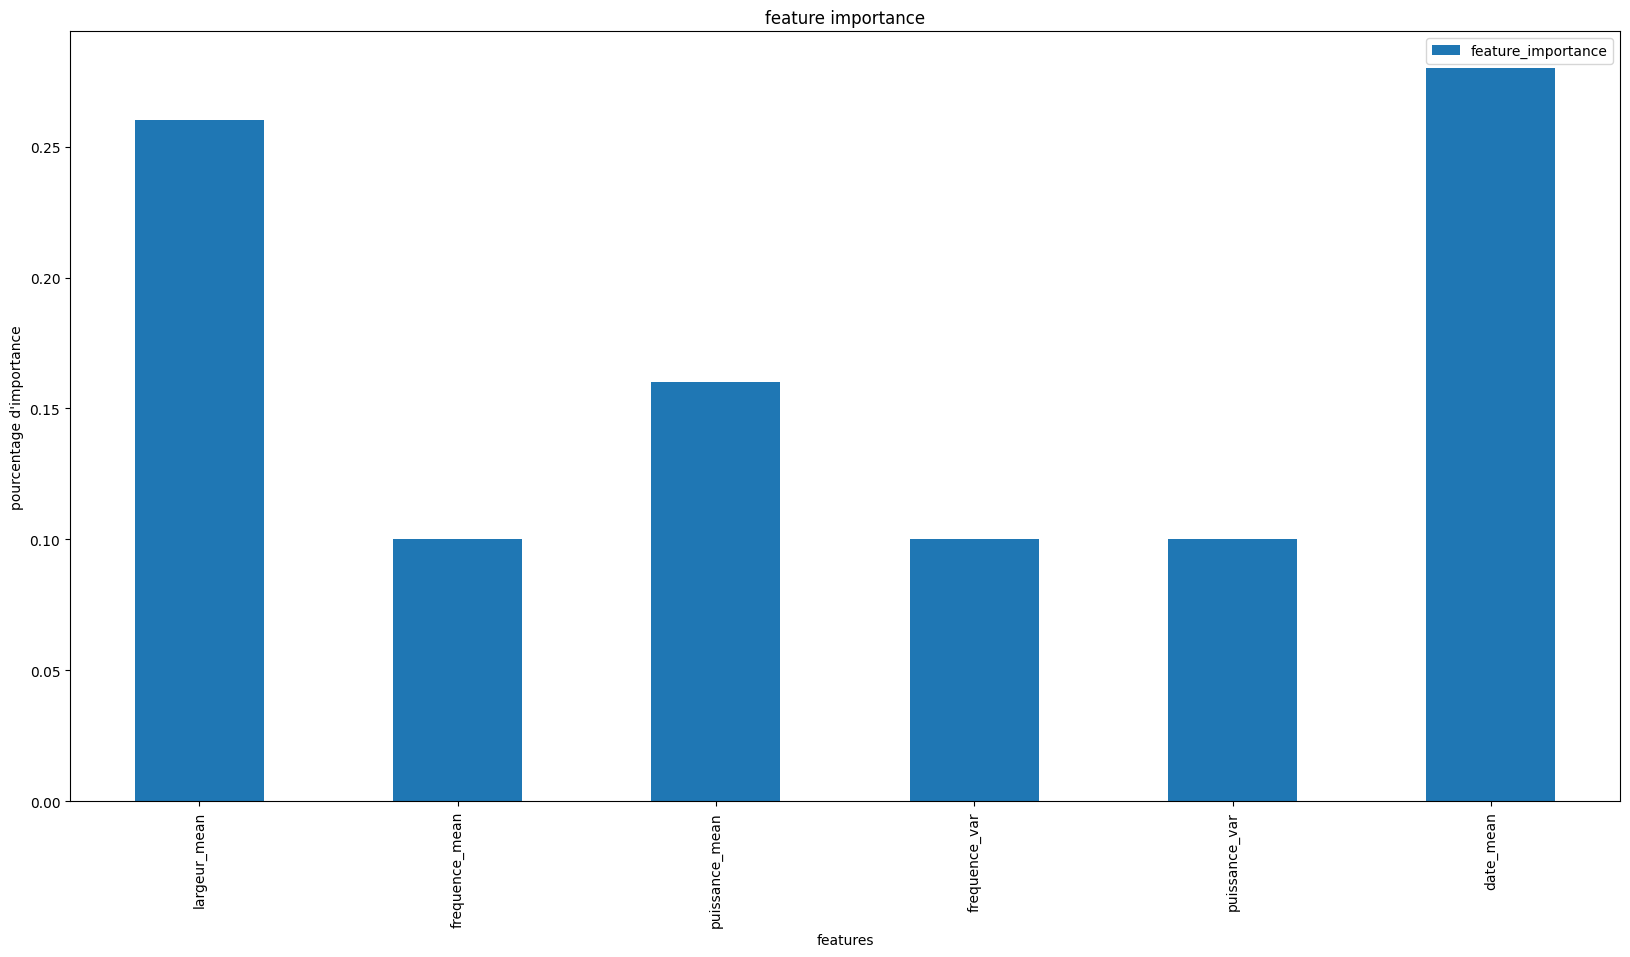

In [30]:
modelAB= AdaBoostClassifier().fit(X_train_selected_features,df_train['label'])
df_1=feature_importance(modelAB, X_train_selected_features)
df_1.plot(kind='bar',figsize=(20,10))
plt.title('feature importance')
plt.xlabel('features')
plt.ylabel('pourcentage d\'importance')
    

Nous remarquons que date_mean et largeur_mean contribuent beaucoup à la décision du modèle. On avait remarqué que le nombre de point max dans les puissances était différents entre les signaux ménaces et non ménace alors nous allons ajouté cette variable à notre dataframe afin de voir comment il impacte la décision du modèle.

In [81]:
import warnings
warnings.filterwarnings('error')
from sklearn.model_selection import GridSearchCV

def nombre_de_max(puissances):
  """
  Elle retourne le nombre de fois par le quel la puissance passe par 0, en d'autre terme le nombre de max
  """
  derivee = np.gradient(puissances)
  x = np.arange(0, len(derivee), 1)
  derivee_clean= UnivariateSpline(x, derivee) # retire les bruits, lissage
  nb_max=((derivee_clean(x)[:-1] * derivee_clean(x)[1:]) < 0).sum()
  return nb_max
X_train_selected_features = X_train_selected_features.copy()
X_test_selected_features = X_test_selected_features.copy()
X_test2_selected_features = X_test2_selected_features.copy()
X_train_selected_features.loc[:, "nb_max"] = df_train.loc[:, "puissance"].apply(nombre_de_max)
X_test_selected_features.loc[:, "nb_max"] = df_test.loc[:, "puissance"].apply(nombre_de_max)
X_test2_selected_features.loc[:, "nb_max"] = df_test2.loc[:, "puissance"].apply(nombre_de_max)

In [32]:
models_train(X_train_selected_features,df_train['label'],X_test_selected_features,df_test['label'])

score of  Nearest Neighbors is 0.71
score of  Decision Tree is 0.8525


score of  Random Forest is 0.8825
score of  AdaBoost is 0.88875
score of  Naive Bayes is 0.835
score of  GB is 0.8875
score of  ET is 0.895
score of  Logistic Regression is 0.78875


Nous remarquons ici que l'ajout de cette nouvelle feature qui calcule le nombre de maxima locaux a un impact significatif sur la performance du model. Tous les modèles ont gagné accuracy

### **Tunning des hyperparamètres**

In [33]:

# Create a AdaBoost classifier object
abc = AdaBoostClassifier()

# Create the parameter grid
param_grid = {
    'n_estimators': [50, 55, 58],
    'learning_rate': [0.2, 0.25, 0.3, 0.5],
    'algorithm': ['SAMME', 'SAMME.R'],
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=abc, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_selected_features, df_train['label'])

# Get the best parameters
best_params = grid_search.best_params_

# Print the best parameters
print(f"Best parameters: {best_params}")

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.3, 'n_estimators': 55}


In [34]:
# Define the model
model = ExtraTreesClassifier()

# Define the parameters for the grid search
param_grid = {
    'n_estimators': [110, 120, 130],
    'max_depth' : [9,10, 11, 12, 13],
    'criterion' :[ 'entropy', 'gini']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid,
    cv=5,  # Number of folds in cross-validation
    scoring='accuracy',  # Scoring metric
    verbose=2  # Output progress
)

# Perform the grid search
grid_search.fit(X_train_selected_features, df_train['label'])

# Print the best parameters and the corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...criterion=entropy, max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=110; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=120; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=120; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=120; total time=   0.2s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=120; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=120; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, n_estimators=130; total time=   0.3s
[CV] END ...criterion=entropy, max_depth=9, n_e

In [61]:
# Create a AdaBoost classifier object
abc = AdaBoostClassifier(n_estimators=55, learning_rate=0.3).fit(X_train_selected_features, df_train['label']) 
print("Score AdaBoost: ", abc.score(X_test_selected_features, df_test['label']))

# Create a ExtraTrees classifier object
etc = ExtraTreesClassifier(n_estimators=110, max_depth=12, criterion='entropy').fit(X_train_selected_features, df_train['label'])
print("Score ExtraTrees: ", etc.score(X_test_selected_features, df_test['label']))


Score AdaBoost:  0.885
Score ExtraTrees:  0.89625


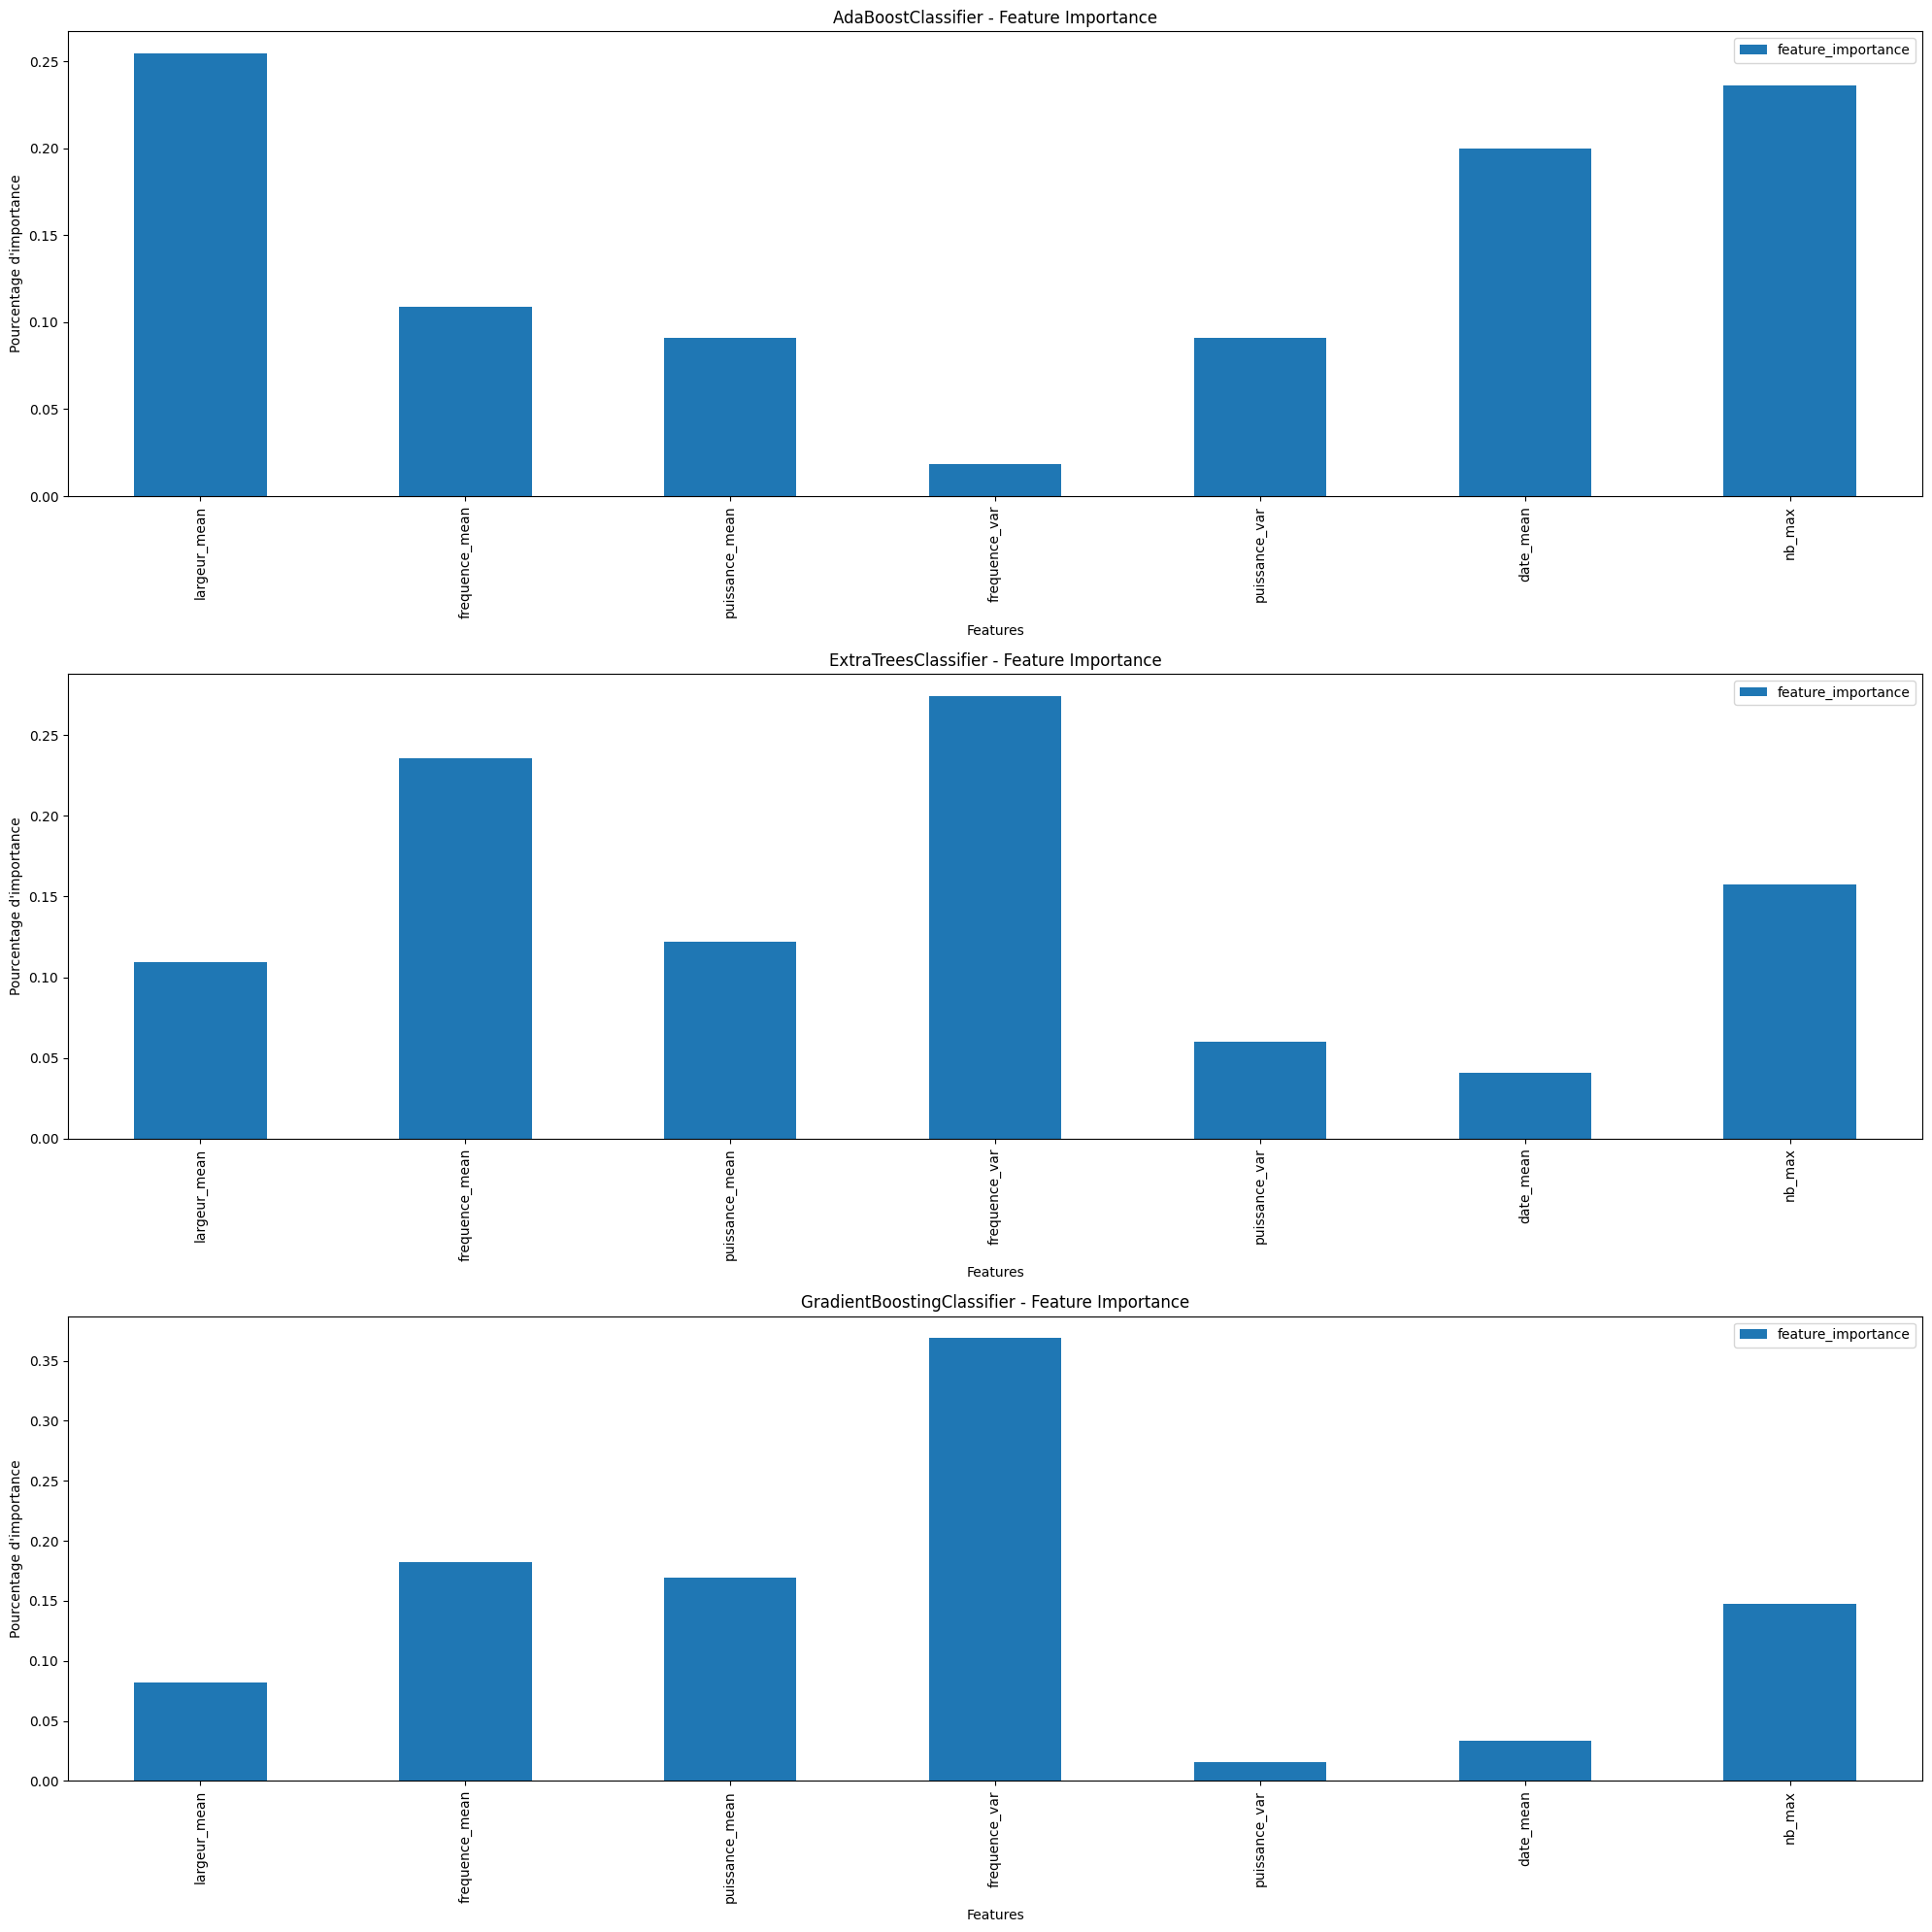

In [92]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(20, 20))  # Create 2 subplots

# AdaBoostClassifier
modelAB = AdaBoostClassifier(n_estimators=55, learning_rate=0.3).fit(X_train_selected_features, df_train['label'])
df_1 = feature_importance(modelAB, X_train_selected_features)
df_1.plot(kind='bar', ax=axs[0])  # Plot on first subplot
axs[0].set_title('AdaBoostClassifier - Feature Importance')
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Pourcentage d\'importance')

# ExtraTreesClassifier
modelAB = ExtraTreesClassifier(n_estimators=110, max_depth=12, criterion='entropy').fit(X_train_selected_features, df_train['label'])
df_1 = feature_importance(modelAB, X_train_selected_features)
df_1.plot(kind='bar', ax=axs[1])  # Plot on second subplot
axs[1].set_title('ExtraTreesClassifier - Feature Importance')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Pourcentage d\'importance')

# GradientBoostingClassifier
modelAB = GradientBoostingClassifier().fit(X_train_selected_features, df_train['label'])
df_1 = feature_importance(modelAB, X_train_selected_features)
df_1.plot(kind='bar', ax=axs[2])  # Plot on third subplot
axs[2].set_title('GradientBoostingClassifier - Feature Importance')
axs[2].set_xlabel('Features')
axs[2].set_ylabel('Pourcentage d\'importance')

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the figure


### Commentaire
Nous remarquons que les scores ont en effet augmenté considérablement après l'ajout de cette nouvelle feature. Cela se voit très bien d'ailleurs sur le premier plot que la feature "nb_max" participe bien assez sur les prédictions du modèle, presqu'autant que la fréquence. Dans le cas des modèle ExtraTrees et GradientBoost, ceci est moins prononcé mais toujours observable. On pourrait donc essayer de tuner sont GradientBoosting( GB), AdaBoosting(AB) et ExtratreesClassifier(ET).

Nous pouvons voir qu'il s'appuie en effet beaucoup sur le nombre de maximun de puissance pour classifier.

Accuracy: 0.88875
Precision: 0.8590308370044053
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       385
           1       0.86      0.94      0.90       415

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800



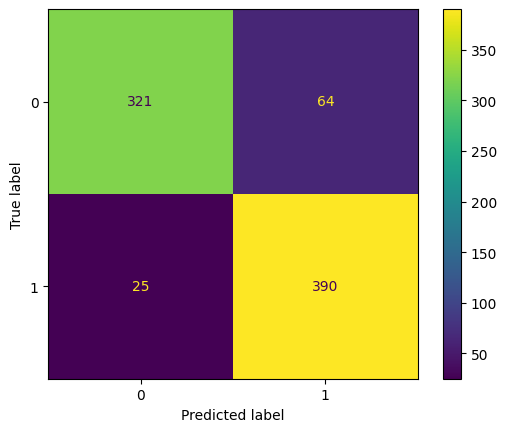

In [60]:
# Confusion matrice avec le meilleur modèle ExtraTreesClassifier
from sklearn.metrics import precision_score, classification_report


clf=ExtraTreesClassifier(n_estimators=110, max_depth=12, criterion='entropy').fit(X_train_selected_features, df_train['label'])
predictions = clf.predict(X_test_selected_features)
cm = confusion_matrix(df_test['label'], predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
# Accuracy
print(f"Accuracy: {accuracy_score(df_test['label'], predictions)}")

# Precision
print(f"Precision: {precision_score(df_test['label'], predictions)}")

# Print classification report
print(classification_report(df_test['label'], predictions))

### Commentaires: 
- Notre meilleur modèle jusqu'à cette étape est le modèle ExtraTreeClassifier, il a correctement identifié 325 menaces. I a identifié 60 non-menaces comme menaces. De même, le modèle a identifié correctement 387 non menaces et il a incorrectement identifié 28 menaces comme des non-menances. Ceci peut-etre préoccupant car le modèle manque parfois des menaces réelles.

### **Scaling the data**

In [51]:
def models_train_with_scaled(X_train, y_train, X_test,y_test):

    pipelines = []
    pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
    LogisticRegression())])))
    pipelines.append(('ScaledLGB', Pipeline([('Scaler', StandardScaler()),('GB',
        GradientBoostingClassifier())])))
    pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
    pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
    pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
    pipelines.append(('ScaledSAD', Pipeline([('Scaler', StandardScaler()),('AD', AdaBoostClassifier())]))) 
    results = []
    names = []
    for name, model in pipelines:
        
        model.fit(X_train, y_train)
        score= model.score(X_test, y_test)
        print('score of  {} is {}'.format(name, score))

In [53]:
models_train_with_scaled(X_train_selected_features,df_train['label'],X_test_selected_features,df_test['label'])

score of  ScaledLR is 0.86875
score of  ScaledLGB is 0.895
score of  ScaledKNN is 0.86625
score of  ScaledCART is 0.85625
score of  ScaledNB is 0.815
score of  ScaledSAD is 0.88125


In [54]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected_features)
X_test_scaled = scaler.transform(X_test_selected_features)

# Gradient Boosting Classifier
gb = GradientBoostingClassifier()
gb.fit(X_train_scaled, df_train['label'])
print("Score Gradient Boosting Classifier with scaled data: ", gb.score(X_test_scaled, df_test['label']))

Score Gradient Boosting Classifier with scaled data:  0.895


On remarque que les résultats avec les donées standardisées ne sont pas très différents des résulats que nous avions précedemment. Néamoins, ceci est le meilleur résultat que nous ayons obtenu.

# **Prédictions sur le test caché**

In [91]:
gb = GradientBoostingClassifier()
gb.fit(X_train_selected_features, df_train['label'])
print("Score on the hidden test Gradient boosting: ", gb.score(X_test2_selected_features, df_test2['label']))

# Extra Trees Classifier
etc = ExtraTreesClassifier()
etc.fit(X_train_selected_features, df_train['label'])
print("Score Extra Trees Classifier with scaled data: ", etc.score(X_test2_selected_features, df_test2['label']))

# AdaBoost Classifier
abc = AdaBoostClassifier()
abc.fit(X_train_selected_features, df_train['label'])
print("Score AdaBoost Classifier with scaled data: ", abc.score(X_test2_selected_features, df_test2['label']))

Score on the hidden test Gradient boosting:  0.90125
Score Extra Trees Classifier with scaled data:  0.8975
Score AdaBoost Classifier with scaled data:  0.88875


# **Conclusion** 

Comme recaputilatif pour ce tp, nous pouvons dire que la phase d'analyse de données est très important dans un projet de machine learning. En effet en détenant les bons features on pourrait avoir un modèle qui performe bien. En gros par les étapes d'analyse des visualisations, de selection des features nous avons pu atteindre les performances du tableau suivant : 
<div style="text-align:center;">

| approche | modèle | score sur le test set|
|:---------:|:---------:|:---------:|
| Moyenne de caractéristique|GradientBoost| 80.5 %|
| combinaison des propriétés des caractériques + selections des meilleures features | Gradient Boost |84.62%|
| Ajout de la feature nombre de maxima de la puissance + features importants de la combinaison|ExtraTrees|89.37% |
| Classification avec données standardisées+features importantes+ajout du nombre de maxima de la puissance|GradientBoosting| 89.5% |
| Score sur le test set caché |GradientBoosting| 90.1% |
</div>
Pour la suite:
<ul>
<li>on pourrait chercher à explorer des modèles plus complexes et plus riches pour voir si on peut améliorer l'accuracy qu'on a ici.</li>
<li>Aussi, plus de feature engineering pourrait permettre de trouver et d'extraire des relations entre plusieurs features, ou alors on pourrait en créer d'autre notamment le fait que toutes les impulsions ne sont pas détectées et ceci encore plus quand la puissance est petite.</li>
<li>
Sur les modèles on pourrait chercher à tuner un peu plus les hyperparamètres pour voir si cela peut améliorer les performances.</li>
</ul>

_____